# Introduction

In this project we will be creating a model which is able to classify whether a blood smear is parasitized or uninfected. The model is trained on a dataset under the Tensorflow Image libraries. It is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.



In [9]:
pip install -q tfds-nightly tensorflow matplotlib

In [10]:
#Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [11]:
# import the modelling libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D # For building neural networks
from tensorflow.keras.models import Model   #Defining neural network architectures
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img    #Reading images from folders
from tensorflow.keras.models import Sequential  #Defining neural network architectures
from glob import glob   #search for files matching a specified pattern in a directory

# Load the dataset

In [13]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

In [14]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


In [15]:
import os
# Define paths for train and test directories
train_path = 'cell_images/Train'
test_path = 'cell_images/Test'

# Create train and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Define the number of samples for testing
num_test_samples = 1000  # Number of samples for testing

# Data Visualization

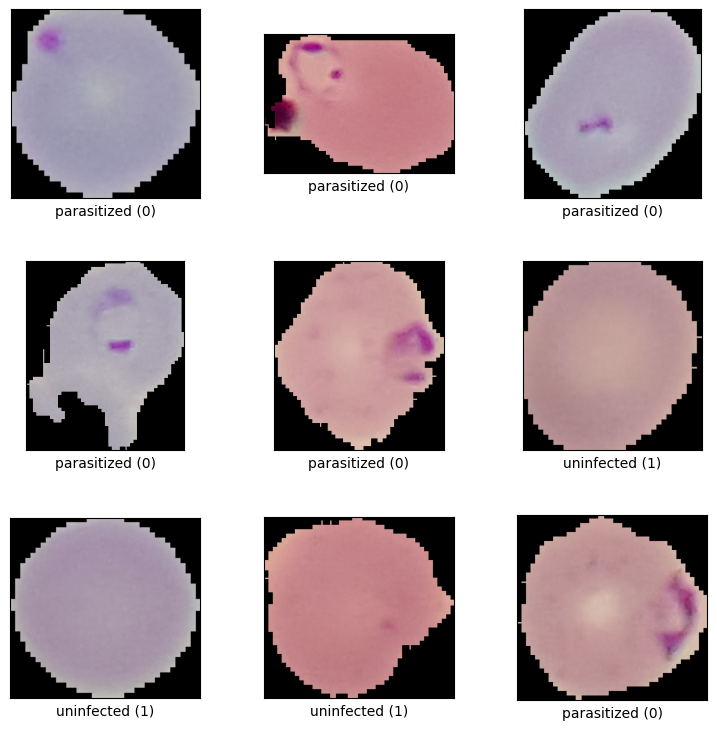

In [16]:
vis = tfds.visualization.show_examples(ds, info)

## Data Preprocessing

In [17]:
# re-size all the images to this
IMAGE_SIZE = [128, 128]

In [18]:
# Preprocess the data
def preprocess(example):
    image = tf.image.resize(example['image'], IMAGE_SIZE)  # Resize images
    label = example['label']
    return image, label

# Resize and save images to train and test directories
for i, example in enumerate(ds):
    image, label = preprocess(example)
    if i < num_test_samples:
        subset_path = test_path
    else:
        subset_path = train_path
    image_filename = f"image_{i}.jpg"
    image_path = os.path.join(subset_path, str(label.numpy()), image_filename)
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    image = tf.cast(image * 255, tf.uint8)  # Convert back to uint8 for saving
    tf.io.write_file(image_path, tf.image.encode_jpeg(image))

## Modelling

In [19]:
# Load pre-trained ResNet50 model
res50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
res50.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
# Add custom classification head
model = models.Sequential([
    res50,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [22]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
#Preparing training data
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 26558 images belonging to 2 classes.


In [24]:
training_set

In [25]:
#Preparing the test data
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 2 classes.


In [26]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
830/830 [==============================] - 179s 197ms/step - loss: 0.6887 - accuracy: 0.5303 - val_loss: 0.6692 - val_accuracy: 0.5800
Epoch 2/10
830/830 [==============================] - 147s 178ms/step - loss: 0.6756 - accuracy: 0.5895 - val_loss: 0.7128 - val_accuracy: 0.5120
Epoch 3/10
830/830 [==============================] - 151s 182ms/step - loss: 0.6695 - accuracy: 0.5982 - val_loss: 0.7127 - val_accuracy: 0.5160
Epoch 4/10
830/830 [==============================] - 150s 181ms/step - loss: 0.6640 - accuracy: 0.6062 - val_loss: 0.6903 - val_accuracy: 0.5440
Epoch 5/10
830/830 [==============================] - 161s 194ms/step - loss: 0.6618 - accuracy: 0.6058 - val_loss: 0.7147 - val_accuracy: 0.5290
Epoch 6/10
830/830 [==============================] - 148s 178ms/step - loss: 0.6588 - accuracy: 0.6112 - val_loss: 0.7172 - val_accuracy: 0.5350
Epoch 7/10
830/830 [==============================] - 148s 178ms/step - loss: 0.6577 - accuracy: 0.6090 - val_loss: 0.7376 -

## Evaluation Metrics

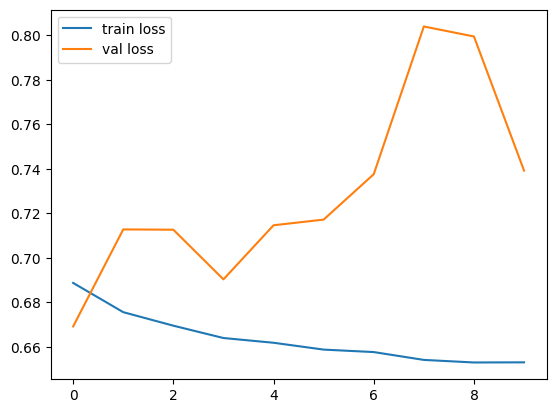

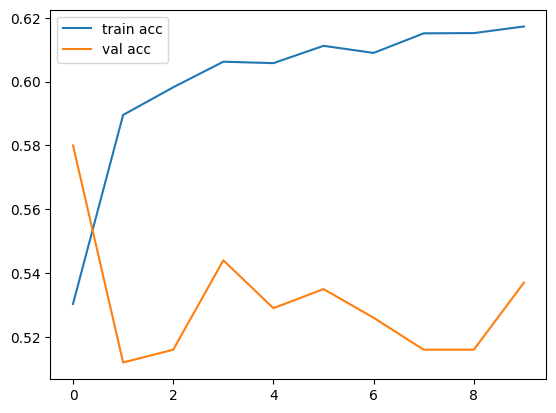

<Figure size 640x480 with 0 Axes>

In [27]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Model Saving and Prediction

In [28]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
#Prediction on test data
y_pred = model.predict(test_set)

32/32 [==============================] - 2s 38ms/step


In [30]:
y_pred

array([[0.17790738, 0.82209265],
       [0.25387898, 0.746121  ],
       [0.15070578, 0.8492942 ],
       ...,
       [0.36479804, 0.635202  ],
       [0.24276242, 0.75723755],
       [0.12347004, 0.87652993]], dtype=float32)

In [31]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)  #returns the indices of the maximum values along a specified axis of an array.

In [32]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [34]:
model=load_model('model_vgg19.h5')

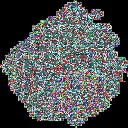

In [36]:
img=image.load_img('cell_images/Test/0/image_101.jpg',target_size=(128,128))
img

In [37]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [38]:
x.shape

(128, 128, 3)

In [39]:
x=x/255

In [40]:
#Preprocessing of an image array
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 128, 128, 3)

In [41]:
model.predict(img_data)

1/1 [==============================] - 2s 2s/step


array([[0.6850663, 0.3149337]], dtype=float32)

In [42]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 42ms/step


In [43]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Infected
